## Triangular Growth Model Demo<br><sup><sub>Gabriel Broussard Korr</sub></sup>

This notebook implements the basic 4-parameter TGM by exactly following the section `§Definition of the Basic Model`. The basic model is capable of recreating Figures 2abde and 9abd, and other figures come from simple modifications of the basic model. Needing only around 120 lines of code, the TGM is quite lightweight!

This implementation has been written in highly *readable* code, making it easier to understand at the cost of significant performance. Thus, it runs much slower than the codebase used for the paper and cannot handle large scales.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#parameters
link_range = 0.18
contraction = 1
mobility = 2
cohesion = 0

#example parameter sets:
    #dendritic:
#link_range = 0.18; contraction = 1; mobility = 2; cohesion = 0 
    #porous:
#link_range = 0.16; contraction = 2; mobility = 0.04; cohesion = 0.4 

#region size
bounds = 3

#coordinates of the starting link ([1,1] = top right corner)
seed_pos = [0.5,0.5]
seed_pos = np.asarray(seed_pos) * bounds #fit into bounds

#usually constant
density = 200
growth_rate = 0.05

In [ ]:
class Particle:
    def __init__(self,pos):
        self.pos = pos #[x,y]
        self.nextpos = pos #used to apply contraction to all particles at once
        self.unlinked = True
        self.contraction_timer = 0
        self.neighbors = [] #list of particles linked to this one

class Link:
    def __init__(self,endpoint1,endpoint2):
        #connects two particle objects; endpoints 1 and 2
        self.endpoint1 = endpoint1
        self.endpoint2 = endpoint2
        self.active = True

In [ ]:
def plot():
    #draw particles
    particleCoords = []
    for particle in particleList: particleCoords.append(particle.pos)
    plt.scatter(*zip(*particleCoords),color='grey',s=0.5)

    #draw links
    for link in linkList: plt.plot([link.endpoint1.pos[0],link.endpoint2.pos[0]],[link.endpoint1.pos[1],link.endpoint2.pos[1]], color='black')
        
    plt.show()

# Initialization

In [6]:
particleList = [Particle(seed_pos)]
linkList = []

#spawn particles
for i in range(int(density * bounds * bounds)):
    particleList.append(Particle(np.random.rand(2) * bounds))

#seed link
linkList.append(Link(particleList[0],particleList[0])) #nearly equivalent to linking to nearest particle

# Growth

In [7]:
def growLinks():
    newLinks = []
    for link in linkList:
        if link.active and np.random.rand() < growth_rate:
            link.active = False #deactivate regardless of if it grows successfully
            nearestParticle = getNearestParticle(link)

            if nearestParticle:
                nearestParticle.neighbors.append(link.endpoint1)
                nearestParticle.neighbors.append(link.endpoint2)
                newLinks.append(Link(link.endpoint1,nearestParticle))
                newLinks.append(Link(link.endpoint2,nearestParticle))
                if nearestParticle.unlinked:
                    nearestParticle.unlinked = False
                    nearestParticle.contraction_timer = contraction / (mobility * growth_rate) #begin contracting that particle
                
    #add new links, ignoring duplicates
    for link in newLinks:
        if link not in linkList:
            linkList.append(link)


def getNearestParticle(link):
    midpoint = (link.endpoint1.pos + link.endpoint2.pos) / 2

    bestDistance = link_range #can't link further than link_range
    nearestParticle = False #default to no valid particle found
    for particle in particleList:
        if particle is link.endpoint1 or particle is link.endpoint2: continue #ignore the endpoints of this link
        if link.endpoint1 in particle.neighbors and link.endpoint2 in particle.neighbors: continue #ignore if a triangle already exists between this particle and the endpoints

        distance = np.linalg.norm(midpoint - particle.pos) #Euclidean distance
        if not particle.unlinked: 
            if cohesion == 0: distance = 1000000 #cannot link to already-linked particles
            else: distance /= cohesion

        if distance < bestDistance:
            bestDistance = distance
            nearestParticle = particle
            
    return nearestParticle

# Contraction

In [8]:
def contractParticles():
    for particle in particleList:
        if particle.contraction_timer > 0:
            particle.contraction_timer -= 1
            centroid = [0,0] #average neighbor pos
            for neighbor in particle.neighbors: centroid += neighbor.pos
            centroid /= len(particle.neighbors)
            
            r = centroid - particle.pos #vector towards centroid
            particle.nextpos = particle.pos + r * mobility * growth_rate
        
    for particle in particleList: particle.pos = particle.nextpos

# Execution

In [9]:
def timestep():
    growLinks()
    contractParticles()

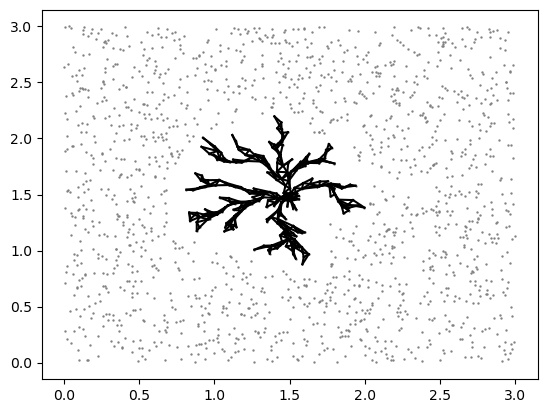

In [33]:
#run this a bunch
for i in range(10): 
    timestep()
plot()

### A Note on Implementation
If you wish to work more with the TGM, I recommend that you reimplement the TGM yourself rather than forking off this python demo. The object-oriented approach shown here is NOT a good way of implementing the TGM; it only makes it intuitive to read.

I suggest replacing each class with a matrix that stores the variables for each particle/link all at once; most optimization to the TGM is achieved through faster data handling techniques like this. Additionally, any serious implementation of the TGM must use some sort of efficient neighbor-searching algorithm in getNearestParticle() to only search close particles. Simple space-partitioning after the particles are generated works well.